In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.metrics import error_rate
from tqdm import tqdm_notebook

torch.cuda.device_count(), torch.cuda.get_device_name(0), torch.version.cuda

(1, 'GeForce GTX 1080 Ti', '9.0.176')

In [2]:
train_labels = pd.read_csv('train_labels.csv', engine='python')
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [3]:
tfms = get_transforms()
data = ImageDataBunch.from_df('', train_labels, 
                              folder='train', test='test', ds_tfms = tfms, 
                              size=128, suffix='.tif')

# DenseNet201

In [4]:
learn = create_cnn(data, models.densenet201, metrics=accuracy)

/home/eigenstir/anaconda3/envs/myfastai/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-03


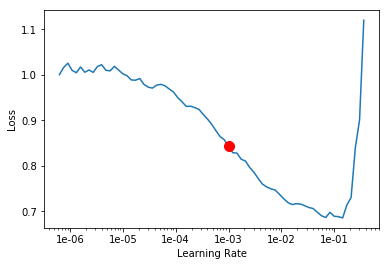

In [5]:
learn.lr_find()
learn.recorder.plot()

In [6]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,accuracy
1,0.217971,0.182948,0.931076
2,0.159817,0.136480,0.952051
3,0.161169,0.116674,0.959959
4,0.125886,0.099171,0.965731
5,0.112562,0.093461,0.967617
6,0.102270,0.091311,0.969072


In [7]:
learn.save('phase_1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07


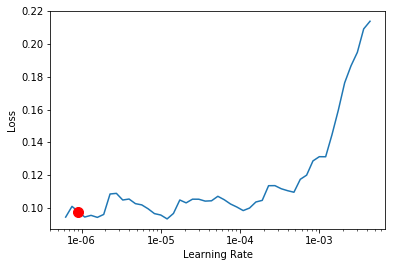

In [8]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [9]:
learn.fit_one_cycle(36, max_lr= slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy
1,0.098561,0.090556,0.968935
2,0.104379,0.090914,0.968640
3,0.091645,0.089031,0.969617
4,0.090080,0.086993,0.970844
5,0.096017,0.085841,0.971390
6,0.092699,0.083175,0.971503
7,0.091201,0.082093,0.972390
8,0.078124,0.082366,0.972412
9,0.081223,0.081150,0.973617
10,0.072412,0.079240,0.974503


In [10]:
learn.save('phase_2')

# DenseNet169

In [16]:
learn = create_cnn(data, models.densenet169, metrics=accuracy)

/home/eigenstir/anaconda3/envs/myfastai/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /home/eigenstir/.torch/models/densenet169-b2777c0a.pth
57365526it [00:55, 1027393.01it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-05


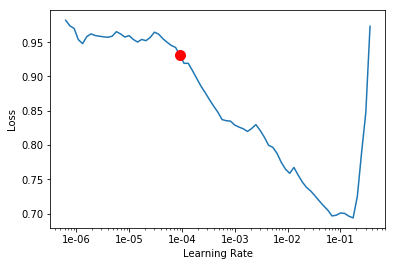

In [17]:
learn.lr_find()
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,accuracy
1,0.240902,0.185208,0.929849
2,0.154214,0.136196,0.950915
3,0.142249,0.120559,0.958505
4,0.120217,0.102976,0.964368
5,0.103137,0.096495,0.966254
6,0.114110,0.095040,0.968049


In [19]:
learn.save('phase_1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06


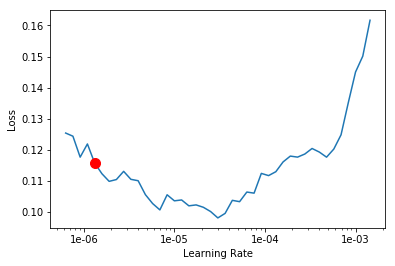

In [20]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(36, max_lr= slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy
1,0.119757,0.095359,0.967504
2,0.106600,0.094330,0.968072
3,0.106050,0.092955,0.968345
4,0.104550,0.091533,0.969163
5,0.091242,0.089412,0.969981
6,0.089092,0.090642,0.968776
7,0.086719,0.086350,0.971390
8,0.092314,0.085292,0.971708
9,0.090507,0.084898,0.971890
10,0.087924,0.079472,0.974071


In [23]:
learn.save('phase_2')

# DenseNet161

In [29]:
learn = create_cnn(data, models.densenet161, metrics=accuracy)

/home/eigenstir/anaconda3/envs/myfastai/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /home/eigenstir/.torch/models/densenet161-8d451a50.pth
115730790it [01:25, 1361368.61it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-04


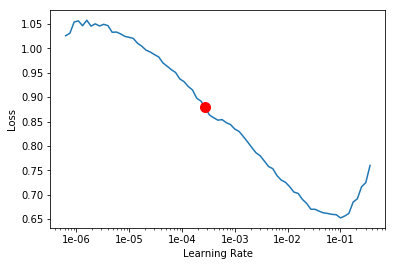

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,accuracy
1,0.227688,0.185355,0.933894
2,0.166318,0.133716,0.951824
3,0.133793,0.116759,0.958800
4,0.117671,0.104530,0.962936
5,0.108800,0.092249,0.967935
6,0.104187,0.092287,0.968026


In [32]:
learn.save('phase_1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06


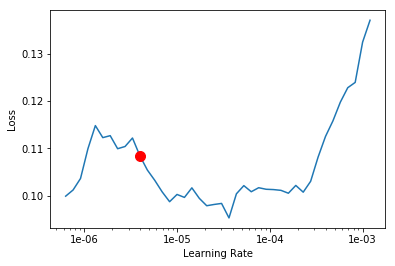

In [33]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(36, max_lr= slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy
1,0.101444,0.091430,0.968208
2,0.103132,0.090986,0.968095
3,0.105982,0.089966,0.968867
4,0.093855,0.086806,0.969844
5,0.099945,0.085499,0.970458
6,0.083472,0.083511,0.971753
7,0.095571,0.082108,0.971390
8,0.085539,0.081170,0.972640
9,0.070324,0.079837,0.972844
10,0.074372,0.079551,0.973185


In [35]:
learn.save('phase_2')

# DenseNet 121

In [41]:
learn = create_cnn(data, models.densenet121, metrics=accuracy)

/home/eigenstir/anaconda3/envs/myfastai/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-04


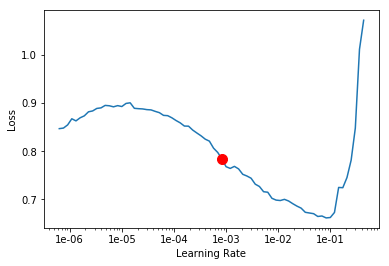

In [42]:
learn.lr_find()
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,accuracy
1,0.244374,0.205867,0.921259
2,0.189333,0.149943,0.945643
3,0.154270,0.126789,0.954346
4,0.147926,0.117965,0.957550
5,0.123796,0.108380,0.962777
6,0.115489,0.105414,0.963913


In [45]:
learn.save('phase_1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06


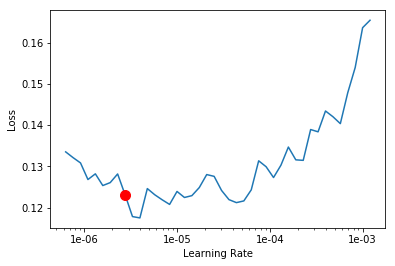

In [44]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [46]:
learn.fit_one_cycle(36, max_lr= slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy
1,0.128613,0.105486,0.963754
2,0.111941,0.105683,0.963822
3,0.117367,0.104038,0.964322
4,0.122206,0.103034,0.964822
5,0.122367,0.101392,0.965777
6,0.110867,0.100438,0.965027
7,0.107217,0.096604,0.966822
8,0.104554,0.095702,0.966572
9,0.106851,0.092562,0.968208
10,0.104233,0.091479,0.968844


In [47]:
learn.save('phase_2')

# Test Time

In [48]:
learn.load('phase_2')

n_aug = 12
preds_n_avg = np.zeros((len(learn.data.test_ds.items),2))

for n in tqdm_notebook(range(n_aug), 'Running TTA...'):
    preds,y = learn.get_preds(ds_type=DatasetType.Test, with_loss=False)
    preds_n_avg = np.sum([preds_n_avg, preds.numpy()], axis=0)
    
preds_n_avg = preds_n_avg / n_aug

In [49]:
tumor_preds = preds_n_avg[:, 1] #get only the predicted probabilities (ie. 70% chance no tumour)
class_preds = np.argmax(preds_n_avg, axis=1) #get the index to predict the class (ie. predict 0, no tumour)

classes = ['Negative','Tumor']
print('Negative and Tumor Probabilities: ' + str(preds_n_avg[0]))
print('Tumor probability: ' + str(tumor_preds[0]))
print('Class prediction: ' + classes[class_preds[0]])

Negative and Tumor Probabilities: [0.054415 0.945585]
Tumor probability: 0.9455854296684265
Class prediction: Tumor


In [50]:
preds_n_avg = np.argmax(preds_n_avg, axis=1) #get the class for each row

SAMPLE_SUB = 'sample_submission.csv'
sample_df = pd.read_csv(SAMPLE_SUB)
sample_list = list(sample_df.id) #get the for the test data

In [51]:
#create a list of predictions that are not sorted [pred3, pred1, pred3...etc] 
pred_list = [p for p in tumor_preds] 

#tie each prediction to the test id inside the model {id: pred}
pred_dic = dict((str(key), value) for (key, value) in zip(learn.data.test_ds.items, pred_list))

#get the prediction for each id in the test set [pred1, pred2, pred3...etc]
pred_list_cor = [pred_dic['test/' + sampId + '.tif'] for sampId in sample_list] 

In [52]:
#save it all out
df_sub = pd.DataFrame({'id':sample_list,'label':pred_list_cor})
df_sub.to_csv('submission.csv', header=True, index=False)